# The Timeseries Quantum Autoencoder - Data Exploration
*Compatible with PennyLane V0.41+*<br/>
*TS QAE in PennyLane with angle encoding of TS sliding windows*

**Author:** Jacob Cybulski<br>
**Date:** September 2025<br>
**Aims:** The goal of this notebook is to build sample data for a Time Series Quantum Autoencoder.

## Data
In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from qae_utils.Files import create_folder_if_needed, write_json_file, write_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg

from matplotlib import set_loglevel
set_loglevel("error")

## Prepare windowed TS data
*Values need to be mapped into qubit state angles, in the range of [0+m..pi-m] where m is some small margin (e.g. 0.05)*

### Prepare time series

In [4]:
## Software version
major_version = 6
minor_version = 1

### Mmackey-Glass settings
beta=0.2     # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=30       # Introduces chaos (try 17–30 for interesting behavior)
x0=1.2       # Initial condition
length=1200  # Length of the generated serties 

### Data encoding
margin = 0.2
scale_low = 0+margin
scale_high = 1 - margin

In [5]:
### Constants
LOG_NAME = 'aintern'
DATA_NAME = f'mackey_glass_tau{tau}'
DATA_PATH = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Create a folder if needed
create_folder_if_needed(DATA_PATH)
create_folder_if_needed(FIGURES_PATH)

### Show constants
(LOG_NAME, DATA_NAME, DATA_PATH, FIGURES_PATH)

('aintern', 'mackey_glass_tau30', 'aintern/data', 'aintern/figures')

### Generate TS data

In [6]:
def scale_values(x, new_min=0, new_max=1):
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / (x_max - x_min)

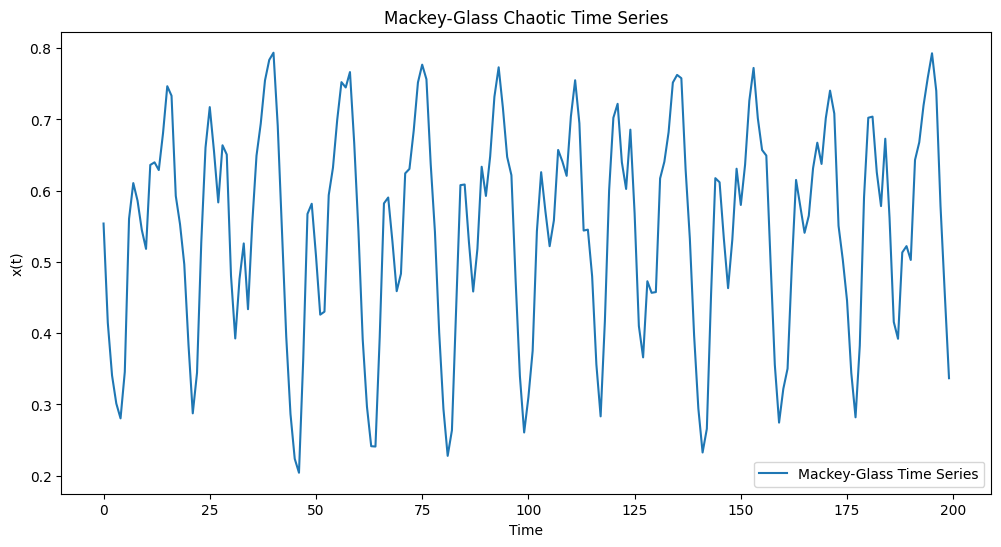

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series
def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float)
    x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]
        xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

# Generate and plot the Mackey-Glass time series
y_raw = mackey_glass(length=length, beta=beta, gamma=gamma, n=n, tau=tau, x0=x0)
y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
y = y_raw[3::6]
X = np.array([i for i in range(len(y))])

plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

## Save generated data

In [8]:
### Data settings
split = 0.75
samples = len(y)

print(f'Samples: all={samples}')

Samples: all=200


In [9]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
DATA_PREF = f'{DATA_NAME}_n{samples}'
DATA_PREF

'mackey_glass_tau30_n200'

In [10]:
### Define file names

x_org_fpath = f'{DATA_PATH}/{DATA_PREF}/x_org.arr'
y_org_fpath = f'{DATA_PATH}/{DATA_PREF}/y_org.arr'

info_file_path = f'{DATA_PATH}/{DATA_PREF}/info.json'

In [11]:
### Save data
#   Note: As noise needs to be generated during training
#         we will not save noisy data


data_to_be_saved = True

if data_to_be_saved:   
    write_ts_file(x_org_fpath, X)
    write_ts_file(y_org_fpath, y)
    print(f'\nSaved all time series data: "{DATA_PATH}" folder\n')
else:
    print(f'\nTime series data not saved\n') 


Saved all time series data: "aintern/data" folder



In [12]:
### Save info details

info_to_save = {\

    # Data ID details
    'data_name':DATA_NAME, 
    'major_version':major_version, 
    'minor_version':minor_version,

    # Data general configuration
    'samples':samples,

    # Data encoding configuration
    'scale_margin':margin,
    'scale_low':scale_low, 
    'scale_high':scale_high,

    # Mackey-Glass configuration
    'mackey_glass_len':length,
    'mackey_glass_beta':beta,
    'mackey_glass_gamma':gamma,
    'mackey_glass_n':n,
    'mackey_glass_tau':tau,
    'mackey_glass_x0':x0,
    }

### Saving the info file
if data_to_be_saved:
    write_json_file(info_file_path, info_to_save)
    print(f'\nSaved time series info in file "{info_file_path}":\n')
else:
    print(f'\nTime series info  not saved:\n') 
    
### Show what has been saved
for k in info_to_save.keys():
    print(f'\tinfo[{k}] = {info_to_save[k]}')
print()


Saved time series info in file "aintern/data/mackey_glass_tau30_n200/info.json":

	info[data_name] = mackey_glass_tau30
	info[major_version] = 6
	info[minor_version] = 1
	info[samples] = 200
	info[scale_margin] = 0.2
	info[scale_low] = 0.2
	info[scale_high] = 0.8
	info[mackey_glass_len] = 1200
	info[mackey_glass_beta] = 0.2
	info[mackey_glass_gamma] = 0.1
	info[mackey_glass_n] = 10
	info[mackey_glass_tau] = 30
	info[mackey_glass_x0] = 1.2



# Software (Linux)

In [13]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
